[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Neural-Networks-Machine-Learning/blob/master/CNN/Convolutional_Neural_Network_time_series.ipynb)

## Convolutional Neural Networks

Convolutional Neural Networks (CNNs, ConvNets, etc.) can be a bit daunting at first glance. They're used extensively in machine learning and image processing today and they deal with mathematical concepts called convolutions. This notebook will show a quick implementation of a ConvNet with PyTorch 1.10.

There are a couple things to pay attention to when designing a network:
1. Make sure your Tensor shapes are correct
2. Make sure your computer can handle the amount of weights. Each filter has it's own weights and it can explode
3. Know if you want to include additional components such as batch normalization or Dropout (extended ideas). I've included BatchNorm here to combat tensors getting too compressed and causing learning issues inside the network
4. Decide which activation function you want to use. We use a ReLU here
5. Finally, decide how many output layers you're going to want. We design this with 1 single fully connected output layer

Overall the structure is a sequential feed forward pattern through 6 convolutional blocks and then through the linear layer. If we wanted, we could add residuals, increase the number of blocks, change the block sizes, the parameters in each convolutional layer, etc. however it is meant to stay relatively simple.

Note, this convolutional neural network is designed to output a binary classification for the problem "Is there an embedded pure sine wave?". If you want to change it to a regression problem or otherwise, you'll need to change the output shape of the network and the loss function (see the fit function).

In [1]:
from typing import List
import torch.nn as nn
from torch import Tensor


class ConvNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 hidden_dims: List = None,
                 output_length: int = 2) -> None:
        super(ConvNet, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 64, 32, 1]

        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm1d(h_dim),
                    nn.ReLU())
            )
            in_channels = h_dim

        self.forward_net = nn.Sequential(*modules)

        self.fcfinal = nn.Linear(4, output_length)


    def forward(self, x: Tensor) -> Tensor:
        x = self.forward_net(x)
        out = self.fcfinal(x)
        return out

## Data Generation

Here we start to generate data. If you intend to use your own data skip the next 4 code blocks. This data is a set of sine waves at 100 Hz combined with pink noise from the colorednoise python library.

In [2]:
import numpy as np

frequency = 100

samples = 2**8

t = np.linspace(0, 1, samples)
sine = 0.1 * np.sin(frequency * 2 * np.pi * t)
print(sine.shape)

(256,)


In [3]:
!pip install colorednoise

#### Combined Noise and Signal

As can be seen in the graph below, the pure pink noise signal and the combined pink noise and sine signal is hardly distinguishable by the human eye. A CNN can make the distinction however.

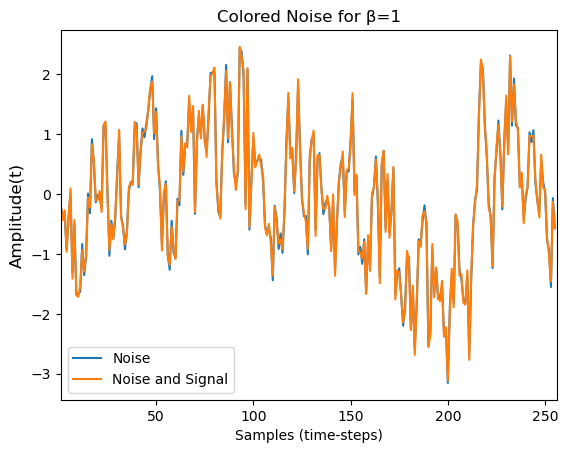

In [4]:
import colorednoise as cn
import matplotlib.pyplot as plt

beta = 1  # pink noise is 1

noise = cn.powerlaw_psd_gaussian(beta, samples)
plt.plot(noise, label='Noise')
plt.plot(noise+sine, label='Noise and Signal')
plt.title('Colored Noise for β='+str(beta))
plt.xlabel('Samples (time-steps)')
plt.ylabel('Amplitude(t)', fontsize='large')
plt.xlim(1,samples)
plt.legend()
plt.show()

#### Building the Dataset

This is when we finally build the dataset. Note we specify the number of samples and let the code determine if the data contains a sine wave or not. This is done through a random choice so that we get a balanced dataset with roughly half the samples containing the sine wave and the other half as pure pink noise. Overall, the input data becomes 10000 samples of a single signal for 256 timesteps. The output is 10000 samples for 1 signal of 2 choices (Contains or Does not Contain a sine wave).

In [5]:
data = []
labels = []
num_samples = 10000
for i in range(num_samples):
    if np.random.randint(low=0.0, high=2.0):
        data.append(cn.powerlaw_psd_gaussian(beta, samples))
        labels.append([1,0])
    else:
        data.append(cn.powerlaw_psd_gaussian(beta, samples) + sine)
        labels.append([0,1])

data = np.stack(data).reshape((num_samples, 1, -1))
labels = np.stack(labels).reshape((num_samples, 1, -1))
print(data.shape)
print(labels.shape)

(10000, 1, 256)
(10000, 1, 2)


#### DataLoaders

DataLoaders are a feature of PyTorch meant to make training easier. Below we just simply split the data to be a 75% training 25% validation split and pass them to the DataLoader with the batch size and whether or not to shuffle the data. Now we are ready to look at training.

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

7500
(10000, 1, 256)
(10000, 1, 2)


#### Training

This is an example of a training loop. Notice it takes both validation and training into account. While this is not necessary, we do it just so we can run both in parallel and maximize our efficiency.

The key lines here are:
```python
loss.backward()
optimizer.step()
```
and this is what allows for training. If you notice, these are only called when using a training dataset because these two lines are the actual backpropagation and updates of the weights in the network. If these lines are not called the network does not learn. The rest is basically built around trying to help the net learn easier (updatable learning rates, loss printing, tqdm, etc.)

*If you want to change the loss function* take a look at the line that says:
```python
loss_func = nn.MSELoss() if 'loss_function' not in kwargs else kwargs.get('loss_function')
```
This basically means we can specify a loss function to the fit function call, or if you want simply change the function from Mean Squared Error here.

In [7]:
from typing import Optional, Tuple
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def fit(model: nn.Module,
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int = 50,
        device: str = 'cpu',
        write_losses: bool = False,
        save_filepath: Optional[str] = None,
        **kwargs) -> Tuple[List, List]:
    """
    Function used to fit the specified model with the provided data
    :param model: neural network pytorch model
    :param training_loader: pytorch dataloader containing the training data
    :param validation_loader: pytorch dataloader containing the validation data
    :param epochs: number of epochs to train
    :param device: which device to train the model on. Should be either "cuda:0" or "cpu"
    :param write_losses: boolean flag as to report losses during training
    :param save_filepath: path to save model, if not specified, no model is saved
    :param kwargs: "optim" optimizer,
                    "loss_function" loss function,
                    "decay_rate" decay rate,
                    "model_save_path" model save path,
                    "loss_save_path" csv save path
    :return: training and validation losses over each epoch
    """
    train_loss_list = []
    val_loss_list = []

    # splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) if 'optim' not in kwargs else kwargs.get('optim')

    loss_func = nn.MSELoss() if 'loss_function' not in kwargs else kwargs.get('loss_function')

    decay_rate = .99995 if 'decay_rate' not in kwargs else kwargs.get('decay_rate')
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    temp_loss = 100000000000000.0

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))

                # backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # calculating total loss
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch % 10 == 0 and write_losses:
            tqdm.write('{} train loss: {.6f} val loss: {.6f}'.format(epoch + 1, train_loss, val_loss))

        # saving best model
        if train_loss < temp_loss and save_filepath:
            torch.save(model, save_filepath)
            temp_loss = train_loss

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


    return train_loss_list, val_loss_list

#### Running the Model

Here its pretty straightforward, simply pass the model, dataloaders, number of epochs, and device to the fit function. We also specify a loss function just to show how it can be done.

In [8]:
import copy

epochs = 100
model = ConvNet()
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device, loss_function=nn.BCEWithLogitsLoss())

  0%|          | 0/100 [00:00<?, ?it/s]

#### Validation

Here we just calculate the results of the validation training dataset to show it in a confusion matrix. Since we are calculating a Binary True/False problem a confusion matrix works perfectly to show how well the model is working.

In [ ]:
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    output_list = None
    y_list = None
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)
        if i == 0:
            output_list = output.to("cpu").detach().numpy()
            y_list = y.to("cpu").detach().numpy()
        else:
            output_list = np.append(output_list, output.to("cpu").detach().numpy(), axis=0)
            y_list = np.append(y_list, y.to("cpu").detach().numpy(), axis=0)
    return np.squeeze(np.argmax(output_list, axis=2)), np.squeeze(np.argmax(y_list, axis=2))


preds, labels = validate_model(model, valid_data, device)
print(preds.shape, labels.shape)

(2500,) (2500,)


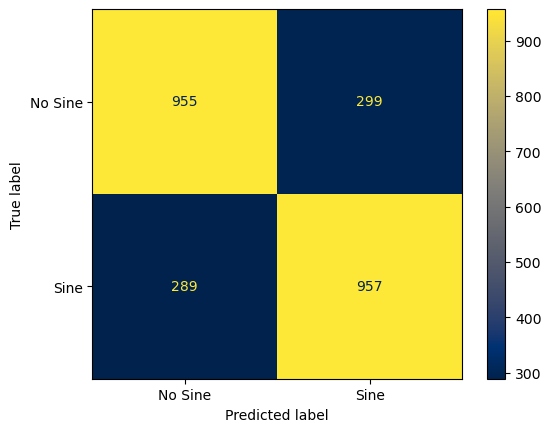

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=['No Sine', 'Sine'], cmap='cividis')
plt.show()